# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [1]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Inspect the shapes of the datasets


# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
print(f'Before one-hot encoding: {y_train[0]}')
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(f'After one-hot encoding: {y_train[0]}')

Before one-hot encoding: 9
After one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


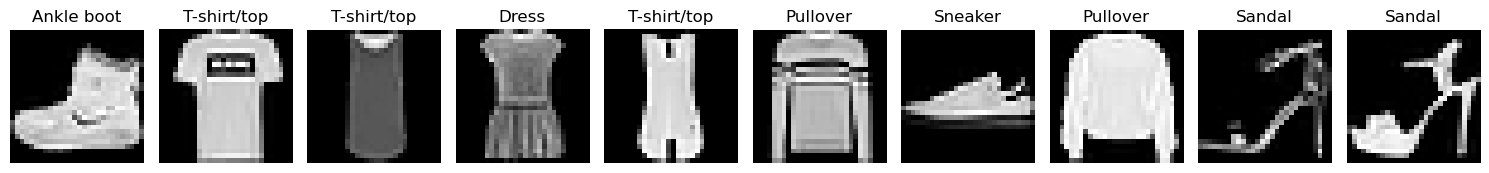

In [4]:
import matplotlib.pyplot as plt
# Verify the data looks as expected

# Number of samples to display
num_samples = 10

# Create a figure with subplots
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[i], cmap='gray')  # Fashion MNIST images are grayscale
    label_index = y_train[i].argmax()    # Convert one-hot back to class index
    plt.title(class_names[label_index])
    plt.axis('off')

plt.tight_layout()
plt.show()

Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

The data looks as expected.  The image quality is a bit low resulting in slight ambiguity in classes like T-shirt/top and dress.  

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a simple linear regression model
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Flatten 2D images to 1D vectors

# You can use `model.add(<layer>)` to add layers to the model
model.add(Dense(10, activation='softmax'))  # Output layer with 10 classes

# Compile the model using `model.compile()`
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with `model.fit()`
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model with `model.evaluate()`
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

c:\Users\annam\miniconda3\envs\dsi_participant\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7922 - loss: 0.6159 - val_accuracy: 0.8372 - val_loss: 0.4741
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8396 - loss: 0.4685 - val_accuracy: 0.8385 - val_loss: 0.4597
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8489 - loss: 0.4403 - val_accuracy: 0.8517 - val_loss: 0.4383
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8552 - loss: 0.4251 - val_accuracy: 0.8525 - val_loss: 0.4226
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8560 - loss: 0.4175 - val_accuracy: 0.8552 - val_loss: 0.4116
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8432 - loss: 0.4496
Test accuracy: 0.8432


Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

Performace is strong for a linear model, especially considering the simplicity of the architecture.  The small gap between training and test accuracy suggests the model is not overfitting.  The model performs at this level because its capacity is limited.  A single dense layer can only learn linear decision boundaries.  There is no feature exraction.  The model sees raw pixel intensities, with no spatial awareness.  28x28 grayscale images limit the amount of visual detail available for classification.

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Create a simple CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

c:\Users\annam\miniconda3\envs\dsi_participant\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8468 - loss: 0.4362 - val_accuracy: 0.8778 - val_loss: 0.3456
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8936 - loss: 0.2994 - val_accuracy: 0.8983 - val_loss: 0.2885
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.9096 - loss: 0.2528 - val_accuracy: 0.9052 - val_loss: 0.2653
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9190 - loss: 0.2210 - val_accuracy: 0.9092 - val_loss: 0.2617
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.9302 - loss: 0.1920 - val_accuracy: 0.9067 - val_loss: 0.2572
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9033 - loss: 0.2715
Test accuracy: 0.9033


Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

Yes, the CNN model clearly outperformed the baseline linear model by 6.0 percentage points. Even a simple CNN with one convolutional layer and one dense layer can significantly outperform a linear model on image data because CNNs process the image in its 2D form, maintaining spatial relationships. The convolutional layer captures local patterns like edges, textures, and shapes, which is crucial for distinguishing similar classes.  

# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.


Testing model with 16 filters

Testing model with 32 filters

Testing model with 64 filters

🔍 Filter Experiment Results:
Filters: 16, Accuracy: 0.9051, Loss: 0.2629
Filters: 32, Accuracy: 0.9091, Loss: 0.2509
Filters: 64, Accuracy: 0.9091, Loss: 0.2537


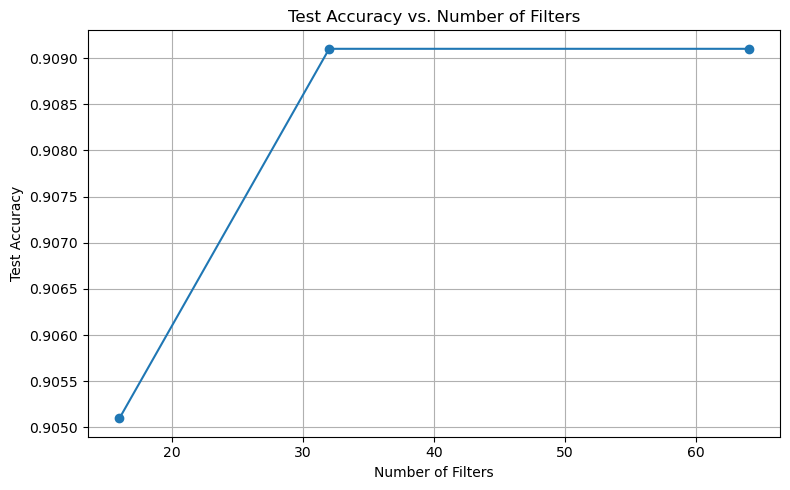

In [7]:
# A. Test Hyperparameters

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Load and preprocess Fashion MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Test different numbers of filters
filter_options = [16, 32, 64]
results_filters = []

for filters in filter_options:
    print(f"\nTesting model with {filters} filters")
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results_filters.append({'filters': filters, 'accuracy': test_acc, 'loss': test_loss})

# Display results
print("\n🔍 Filter Experiment Results:")
for r in results_filters:
    print(f"Filters: {r['filters']}, Accuracy: {r['accuracy']:.4f}, Loss: {r['loss']:.4f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot([r['filters'] for r in results_filters], [r['accuracy'] for r in results_filters], marker='o')
plt.title('Test Accuracy vs. Number of Filters')
plt.xlabel('Number of Filters')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()



Testing model with dropout=False

Testing model with dropout=True

🛡️ Dropout Experiment Results:
Dropout: False, Accuracy: 0.9129, Loss: 0.2464
Dropout: True, Accuracy: 0.9039, Loss: 0.2673


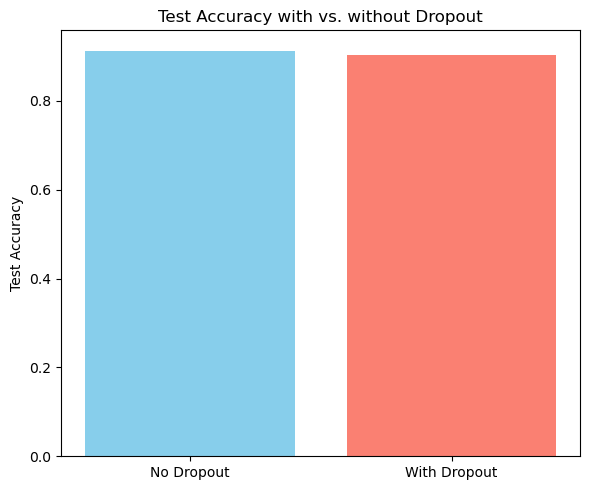

In [8]:
# B. Test presence or absence of regularization

from tensorflow.keras.layers import Dropout

# Use fixed number of filters for this test
filters = 32
dropout_options = [False, True]
results_dropout = []

for use_dropout in dropout_options:
    print(f"\nTesting model with dropout={use_dropout}")
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results_dropout.append({'dropout': use_dropout, 'accuracy': test_acc, 'loss': test_loss})

# Display results
print("\n🛡️ Dropout Experiment Results:")
for r in results_dropout:
    print(f"Dropout: {r['dropout']}, Accuracy: {r['accuracy']:.4f}, Loss: {r['loss']:.4f}")

# Plot results
plt.figure(figsize=(6, 5))
labels = ['No Dropout', 'With Dropout']
accs = [r['accuracy'] for r in results_dropout]
plt.bar(labels, accs, color=['skyblue', 'salmon'])
plt.title('Test Accuracy with vs. without Dropout')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()


Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

Increasing the number of filters from 16 to 32 improved accuracy from 90.51% to 90.91% and removing dropout further boosted accuracy to 91.29%, the highest across all experiments.  More filters allowed the model to learn richer and more diverse spatial features. No dropout helped the model retain full capacity during training, which worked well given the dataset's simplicity and size.  Best performing configuration is 32 filters without dropout.  

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [9]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Build final model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Final Model Performance:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8492 - loss: 0.4295 - val_accuracy: 0.8847 - val_loss: 0.3231
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.8975 - loss: 0.2875 - val_accuracy: 0.9022 - val_loss: 0.2767
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9125 - loss: 0.2427 - val_accuracy: 0.9075 - val_loss: 0.2593
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9229 - loss: 0.2134 - val_accuracy: 0.9078 - val_loss: 0.2536
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9311 - loss: 0.1872 - val_accuracy: 0.9167 - val_loss: 0.2439
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9088 - loss: 0.2548

🎯 Final Model Performance:
Test Accuracy: 0.9088
Test Loss: 0.2548


Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

Final CNN (32 layers, no dropout) model outperformed initial CNN (0.2548 vs. 0.2715 in test loss) and baseline linear model (0.9088 vs. 0.8432 in test accuracy).  Simple, but effective architecture allowed the model to capture spatial hierarchies without unnecessary complexity, balanced filter count (32) and no dropout regularization contributed to the better performance.  To further improve the model's performance, a second Conv2D layer could be added to capture deeper spatial features and patterns, longer training (10-20 epochs) would allow deeper convergence, learning rate schedules could be used to refine optimization.

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 26/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.